In [1]:
import numpy as np
from scipy.special import gammaln, binom
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt

- $N$ - total nodes
- $F$ - max fraction of faulty nodes in the network
- $t = n \cdot F$ - total faulty nodes
- $n$ - shard size
- $f$ - max fraction of faulty nodes in a shard
- $X$ - number of faulty nodes in a shard
- Committees do not intersect with each other
- Assignment of nodes to shards is changed once every hour


$$
p_{\texttt{local\_fail}} \coloneqq
\mathbb{P}\left(X \geq\lceil n \cdot f \rceil \right) =
\sum_{x=\lceil n \cdot f \rceil}^n
\frac{\binom{t}{x} \binom{N-t}{n-x}}{\binom{N}{n}}
$$

$$
p_{\texttt{fail}} < \left\lceil \frac{N}{n} \right\rceil p_{\texttt{local\_fail}}
$$

$$
\text{expected time to fail} = \frac{1}{p_{\texttt{fail}}}
$$

In [2]:
def committee_fail(total_size, shard_size, total_faulty=1/3, shard_faulty=1/2):
    sum = 0
    faulty_shard_size = int(shard_size * shard_faulty)
    faulty_size = int(total_size * total_faulty)

    for x in range(faulty_shard_size, shard_size + 1):
        term = binom(faulty_size, x) * binom(total_size - faulty_size, shard_size - x)
        sum += term

    return sum / binom(total_size, shard_size)

def two_committee_fail(total_size, shard_size, total_faulty=1/3, shard_faulty=1/2):
    sum = 0
    faulty_shard_size = int(shard_size * shard_faulty)
    faulty_size = int(total_size * total_faulty)

    for x in range(faulty_shard_size, shard_size + 1):
        x_term = binom(faulty_size, x) * binom(total_size - faulty_size, shard_size - x)
        y_term = 0
        for y in range(faulty_shard_size, shard_size + 1):
            y_term += binom(faulty_size - x, y) * binom(total_size - faulty_size - (shard_size - x), shard_size - y)
        sum += x_term * y_term

    return sum / binom(total_size, shard_size) / binom(total_size - shard_size, shard_size)

def log_binom(n, k):
    return gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)

def committee_fail_optimized(total_size, shard_size, total_faulty=1/3, shard_faulty=1/2):
    log_sum = 0
    faulty_shard_size = int(shard_size * shard_faulty)
    faulty_size = int(total_size * total_faulty)

    for x in range(faulty_shard_size, shard_size + 1):
        log_term = log_binom(faulty_size, x) + log_binom(total_size - faulty_size, shard_size - x)
        log_sum = np.logaddexp(log_sum, log_term) if log_sum else log_term

    log_binom_total_shard = log_binom(total_size, shard_size)

    prob = np.exp(log_sum - log_binom_total_shard)
    return prob

committee_fail_optimized(2000, 220), committee_fail(2000, 220)

(4.136636628669624e-08, 4.136636628670898e-08)

# Estimation on the shards's failure probability

In [3]:
total_size = 1000
shard_sizes = np.arange(10, 901, 50)
shard_faulty_values = [1/2, 1/3 + 1/10, 1/3 + 1/20, 1/3]

fig = go.Figure()

for shard_faulty in shard_faulty_values:
    fail_probs = [
        committee_fail_optimized(total_size, shard_size, shard_faulty=shard_faulty, total_faulty=1/3) for shard_size in shard_sizes
    ]
    fig.add_trace(go.Scatter(x=shard_sizes,
                             y=fail_probs,
                             mode='lines+markers',
                             name=f'f={shard_faulty:.2f}'))

fig.update_layout(
    title=f"Committee Failure Probability vs Shard Size, Total Size = {total_size}",
    xaxis_title="Shard Size",
    yaxis_title="Failure Probability",
    yaxis_type="log",
    xaxis=dict(range=[min(shard_sizes), max(shard_sizes)]),
    yaxis=dict(range=[np.log10(min(min(fail_probs), 1e-4)), 0])
)

fig.add_shape(type="line", x0=min(shard_sizes), x1=max(shard_sizes), y0=1e-7, y1=1e-7,
              line=dict(color="RoyalBlue", width=2, dash="dash"),
              name="Millennium cluster")

fig.add_annotation(
    x=max(shard_sizes), y=np.log10(1e-7),
    text="Millennium cluster",
    showarrow=False,
    yshift=-10
)

fig.add_shape(type="line", x0=min(shard_sizes), x1=max(shard_sizes), y0=3e-3, y1=3e-3,
              line=dict(color="Red", width=2, dash="dash"),
              name="Annual cluster")

fig.add_annotation(
    x=max(shard_sizes), y=np.log10(3e-3),
    text="Annual cluster",
    showarrow=False,
    yshift=-10
)

fig.show()

# Estimation on the cluster's failure probability

In [9]:
total_size = 1000
shard_sizes = np.arange(10, 901, 50)
shard_faulty_values = [1/2, 1/3 + 1/10, 1/3 + 1/20, 1/3]

fig = go.Figure()

for shard_faulty in shard_faulty_values:
    fail_probs = [
        committee_fail_optimized(total_size, shard_size, shard_faulty=shard_faulty, total_faulty=1/3) for shard_size in shard_sizes
    ]
    fig.add_trace(go.Scatter(
        # x=shard_sizes, y=[1 - (1 - fail_prob) ** (total_size / shard_size)
        x=shard_sizes, y=[math.ceil(total_size / shard_size) * fail_prob
                          for shard_size, fail_prob in zip(shard_sizes, fail_probs)],
        mode='lines+markers', name=f'f = {shard_faulty:.2f}'
    ))

fig.update_layout(
    title=f"Upper estimate on the cluster Failure Probability vs Shard Size, Total Size = {total_size}",
    xaxis_title="Shard Size",
    yaxis_title="Failure Probability",
    yaxis_type="log",
    xaxis=dict(range=[min(shard_sizes), max(shard_sizes)]),
    yaxis=dict(range=[np.log10(min(min(fail_probs), 1e-4)), 0])
)

fig.add_shape(type="line", x0=min(shard_sizes), x1=max(shard_sizes), y0=1e-7, y1=1e-7,
                line=dict(color="RoyalBlue", width=2, dash="dash"),
                name="Millennium cluster")

fig.add_annotation(
    x=max(shard_sizes), y=np.log10(1e-7),
    text="Millennium cluster",
    showarrow=False,
    yshift=-10
)

fig.add_shape(type="line", x0=min(shard_sizes), x1=max(shard_sizes), y0=3e-3, y1=3e-3,
                line=dict(color="Red", width=2, dash="dash"),
                name="Annual cluster")

fig.add_annotation(
    x=max(shard_sizes), y=np.log10(3e-3),
    text="Annual cluster",
    showarrow=False,
    yshift=-10
)


fig.show()        

# Several shards are failing at the same time

Probability of 2 particular shards failing at the same time:
$$
\mathbb{P}\bigl(\text{2 particular shards fail}\bigr) = 
\frac{1}{\binom{N}{n}\,\binom{N - n}{n}}
\sum_{x=\lceil n \cdot f \rceil}^n
\sum_{y=\lceil n \cdot f \rceil}^n
\binom{t}{x}\,\binom{N - t}{n - x}
\binom{t - x}{y}\,\binom{(N - t) - (n - x)}{\,n - y}
$$

In general, we have the following inequality:
$$
\mathbb{P}\left(\text{k particular shards fail}\right) < \mathbb{P}\left(\text{one shard fails}\right)^k
$$
Sketch of the proof:
- Initially, we have $N$ nodes and $t$ faulty nodes, so the probability of picking a faulty node is $F = t/N$.
- After forming the first malicious shard, we have $N - n$ nodes and $t - X$ faulty nodes, where $X \in [\lceil n \cdot f \rceil, n]$.
- The probability of picking a faulty node is $F' \coloneqq (t - X)/(N - n)$.
- Under our assumption, that $f > F$, we have $F' < F$.
- That means that the probability of picking a faulty node will decrease with each **malicious** shard formed.

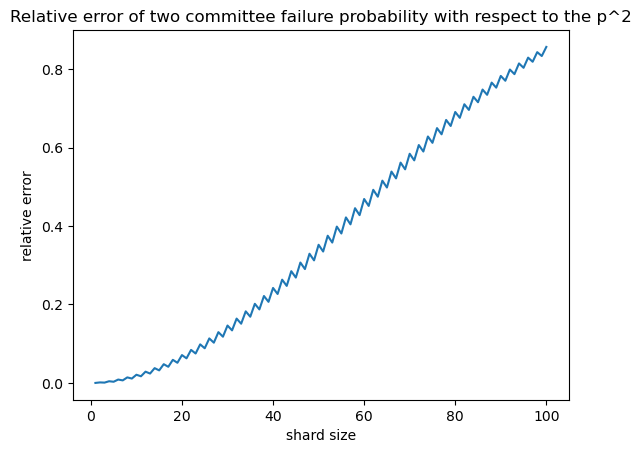

In [5]:
total_size = 1000
shard_sizes = np.arange(1, int(total_size/10) + 1)
probabilities = {'p': [], 'p^2': [], 'p_2': [], 'relative': []}
for shard_size in shard_sizes:
    probabilities['p'].append(committee_fail(total_size, shard_size))
    probabilities['p^2'].append(committee_fail_optimized(total_size, shard_size)**2)
    probabilities['p_2'].append(two_committee_fail(total_size, shard_size))
    probabilities['relative'].append((probabilities['p^2'][-1] - probabilities['p_2'][-1]) / probabilities['p^2'][-1])
plt.figure()
plt.plot(shard_sizes, probabilities['relative'], label='relative error')
plt.xlabel('shard size')
plt.ylabel('relative error')
plt.title('Relative error of two committee failure probability with respect to the p^2')
plt.show()

# Birthday paradox collision probability

In [6]:
total = 2**80 * 1.0

def proba_approx(n, d):
    # probability of a collision
    return 1 - np.exp(-n**2 / 2 / d)

In [7]:
num_accounts = [10**i for i in range(5, 14)]
proba = [proba_approx(n, total) for n in num_accounts]

# plot the results in log log scale
fig = go.Figure()

fig.add_trace(go.Scatter(x=num_accounts, y=proba, mode='lines+markers'))

fig.update_layout(
    title="Probability of a collision in a 80-bit space",
    xaxis_title="Number of accounts",
    yaxis_title="Probability of a collision",
    xaxis_type="log",
    yaxis_type="log"
)

fig.show()
